In [53]:
import importlib, os
import numpy as np
import pandas as pd
from hmmlearn.hmm import GaussianHMM
from tqdm.notebook import tqdm
import data_processing.import_data as imp
import data_processing.partition_data as prt
from data_processing.load_env import load_env
import plot_functions.format_axis as fmt

In [2]:
long_data = imp.import_all_longitudinal_files(clean_only=True, add_demog=True)

IMPORTING LONGITUDINAL DATA FROM:
	/Users/akre96/Data/DGC_Study/Longitudinal Data with New Barometric Data
	Only importing patients with demographic information, and data until end of study
	Removed 0 subjects 33 remain
	Filtering for time points newer than June 2016
	Adding Demographic information to longitudinal data


In [4]:
importlib.reload(imp)
env = load_env()
sub_dir, files, paths = imp.generate_subject_file_path_list(env)

## Assessing amount of data available if split based on redcap events

In [50]:
importlib.reload(prt)
phase_count_dict = {
    'subject_id': [],
    'phase_start': [],
    'phase_len': [],
}
for fp in tqdm(paths):
    s_data = imp.import_longitudinal_file(fp, True)
    s_id = s_data.subject_id.unique()[0]
    phases = [
        'baseline_arm_1',
        'remote_cat_1_arm_1',
        'remote_cat_2_arm_1',
        'remote_cat_3_arm_1',
        'remote_cat_4_arm_1',
        'remote_cat_5_arm_1',
        'remote_cat_6_arm_1',
        'followup_assessmen_arm_1'
    ]
    for i in range(len(phases)-1):
        start = phases[i]
        end = phases[i+1]
        first_row = s_data[s_data.redcap_event_name_1 == start]
        last_row = s_data[s_data.redcap_event_name_1 == end]
        if first_row.empty or last_row.empty:
            continue
        if (first_row.shape[0] > 1) or (last_row.shape[0] > 1):
            print('Warning: multiple entries for first or last row, using first')
            print(first_row.shape[0], last_row.shape[0])
        chunk = s_data.iloc[first_row.index[0]:last_row.index[0]] 
    
        phase_count_dict['subject_id'].append(s_id)
        phase_count_dict['phase_start'].append(start.split('_arm_1')[0])
        phase_count_dict['phase_len'].append(chunk.shape[0])
    

In [72]:
import matplotlib.pyplot as plt
import seaborn as sns

data_count = pd.DataFrame.from_dict(phase_count_dict)
data_count.describe()

,phase_len
count,191.000000
mean,13.565445
std,3.432762
min,1.000000
25%,13.000000
50%,14.000000
75%,14.000000
max,28.000000


subject_id                                                  m2_0005
Date                                            2017-12-01 00:00:00
Calories (kcal)                                             1527.43
Distance (mi)                                              0.671818
Average heart rate (bpm)                                        NaN
Max heart rate (bpm)                                            NaN
Min heart rate (bpm)                                            NaN
Step count                                                     7929
swtype                                                      Android
device_id_call                 63b8543e-ba1a-472b-948c-f23362bf7587
total_calls                                                       2
incoming_calls                                                    2
outgoing_calls                                                    0
ratio_of_outgoing_calls                                           0
device_id_message              63b8543e-ba1a-472

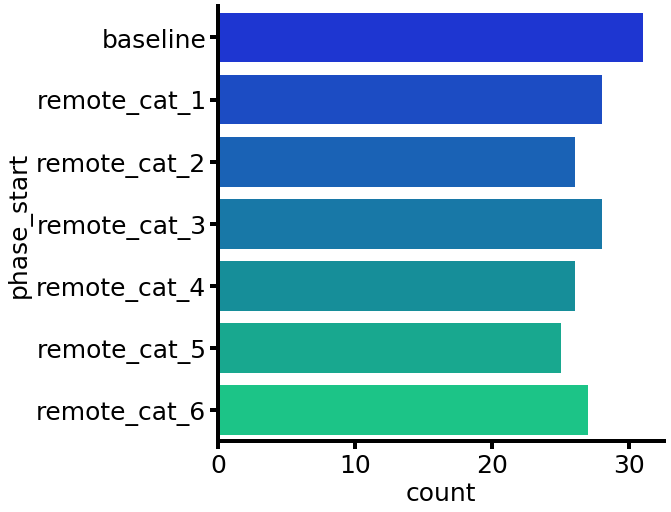

In [71]:
fig, ax = plt.subplots(figsize=(8,8))
sns.countplot(
    y=data_count.phase_start,
    ax=ax,
    palette='winter'
)
fmt.despine_thicken_axes(
    ax=ax,
    lw=4,
    fontsize=25,
    rotate_x=0,
)
sns.despine()

phase_len                                                     
                 count       mean       std   min    25%   50%    75%   max
phase_start                                                                
baseline          31.0  14.548387  1.524002  14.0  14.00  14.0  14.00  20.0
remote_cat_1      28.0  15.071429  2.827492   8.0  14.00  14.0  16.00  23.0
remote_cat_2      26.0  13.923077  1.354196  10.0  14.00  14.0  14.75  17.0
remote_cat_3      28.0  14.250000  2.428610   8.0  13.75  14.0  15.00  22.0
remote_cat_4      26.0  14.423077  2.157277   9.0  13.25  14.0  14.75  19.0
remote_cat_5      25.0  13.960000  3.656957   9.0  13.00  14.0  14.00  28.0
remote_cat_6      27.0   8.629630  4.473410   1.0   6.00   8.0  11.50  21.0

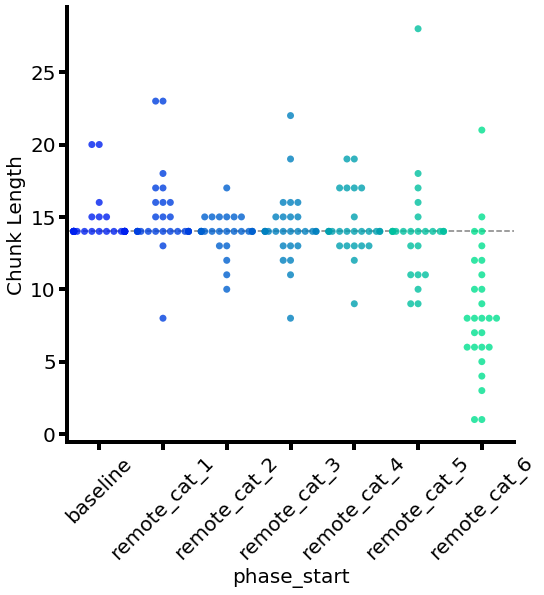

In [75]:

fig, ax = plt.subplots(figsize=(8,8))
sns.swarmplot(
    x='phase_start',
    y='phase_len',
    data=data_count,
    palette='winter',
    ax=ax,
    s=7,
    alpha=0.8
)
ax.hlines([14],ax.get_xlim()[0], ax.get_xlim()[1], ls='dashed', color='gray')
fmt.despine_thicken_axes(
    ax=ax,
    lw=4,
    fontsize=20,
    rotate_x=45,
)
ax.set_ylabel('Chunk Length')
sns.despine()
data_count.groupby('phase_start').describe()

## Splitting Data in to two week chunks, creating HMM inputs

- for now just step count change

In [133]:
# Isolate one file for testing
i=2
f, fp = files[i], paths[i]
print(f,'\n',fp)


m2_0009_Migraine_Longitudinal_Data.xlsx 
 /Users/akre96/Data/DGC_Study/Longitudinal Data with New Barometric Data/m2_0009_Migraine_Longitudinal_Data.xlsx


In [134]:
importlib.reload(imp)
importlib.reload(prt)
chunks = prt.two_week_subsets(imp.import_longitudinal_file(fp, True), 14)



In [195]:
min_days = 10
lengths = []
sequences = []
end_sevs = []
start_sevs = []
for fp in tqdm(paths):
    chunks = prt.two_week_subsets(imp.import_longitudinal_file(fp, True), min_days)
    sequence = []
    for d in chunks:
        data = d.sort_values(by='Date', ascending=True)
        h1, h2 = prt.split_half(data)

        if 'Step count' in data.columns:
            step_dif = h2['Step count'].mean() - h1['Step count'].mean()
            if np.isnan(step_dif):
                continue
            sev_init = data['start_sev'].unique()[0]
            event = [step_dif, sev_init]
            end_sevs.append(data.end_sev.unique()[0])
            start_sevs.append(sev_init)
            sequence.append(event)
    if len(sequence):
        sequences.append(np.array(sequence))
        lengths.append(len(sequence))
    

/Users/akre96/Code/DGC_Study/venv/lib/python3.7/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/akre96/Code/DGC_Study/venv/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


No Depression Severity m2_0020
No Depression Severity m2_0020
No Depression Severity m2_0008



In [196]:
X = np.concatenate(sequences)
print(X.shape, len(lengths))

(148, 2) 29


## Training HMM

In [206]:
model = GaussianHMM(n_components=3).fit(X, lengths)

In [207]:
model

GaussianHMM(algorithm='viterbi', covariance_type='diag', covars_prior=0.01,
            covars_weight=1, init_params='stmc', means_prior=0, means_weight=0,
            min_covar=0.001, n_components=3, n_iter=10, params='stmc',
            random_state=None, startprob_prior=1.0, tol=0.01,
            transmat_prior=1.0, verbose=False)

In [208]:
model.predict(sequences[0])

array([0, 0, 0])

In [209]:
model.predict(X, lengths)

array([0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 0, 0, 1, 1, 1, 1, 2, 2, 2, 0, 0,
       0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1,
       1, 0, 0, 0, 2, 2, 2, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2,
       2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 0, 0, 1, 1,
       2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 0, 0, 2, 2, 2, 2,
       2, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 2, 2, 2, 2])

Text(0.5, 0, 'Output Class')

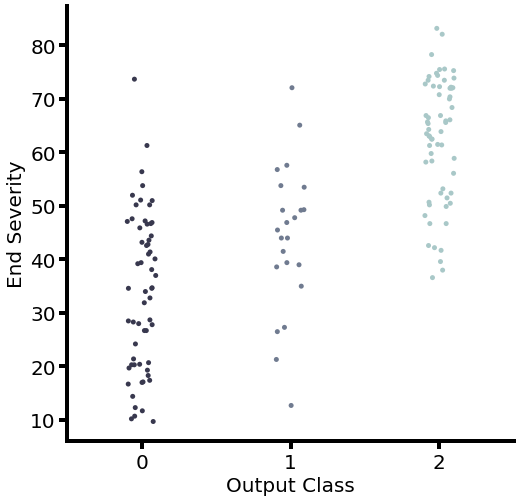

In [210]:
fig, ax = plt.subplots(figsize=(8,8))
diffs = np.array(end_sevs) - np.array(start_sevs)
sns.stripplot(
    x=model.predict(X, lengths),
    y=end_sevs,
    palette='bone'
)
fmt.despine_thicken_axes(
    ax=ax,
    lw=4,
    fontsize=20,
)
ax.set_ylabel('End Severity')
ax.set_xlabel('Output Class')

Text(0.5, 0, 'Output Class')

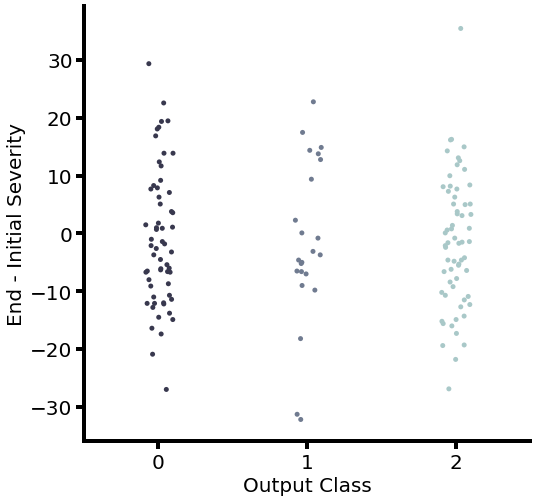

In [211]:

fig, ax = plt.subplots(figsize=(8,8))
diffs = np.array(end_sevs) - np.array(start_sevs)
sns.stripplot(
    x=model.predict(X, lengths),
    y=diffs,
    palette='bone'
)
fmt.despine_thicken_axes(
    ax=ax,
    lw=4,
    fontsize=20,
)
ax.set_ylabel('End - Initial Severity')
ax.set_xlabel('Output Class')